In [26]:
import pybullet as p
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt


## these are the parameters sent to bullet, currently set up to mimic what I'm seeing in mujoco
physics_params = {
    'fixedTimeStep': 0.002,
    'numSubSteps': 0,
    'numSolverIterations': 50,
    'useSplitImpulse': 1,
    'splitImpulsePenetrationThreshold': -0.03999999910593033,
    'contactBreakingThreshold': 0.02,
    'collisionFilterMode': 1,
    'enableFileCaching': 1,
    'restitutionVelocityThreshold': 0.20000000298023224,
    'erp': 0.0,
    'frictionERP': 0.0,
    'contactERP': 0.0,
    'globalCFM': 0.0,
    'enableConeFriction': 0,
    'deterministicOverlappingPairs': 1,
    'allowedCcdPenetration': 0.04,
    'jointFeedbackMode': 0,
    'solverResidualThreshold': 1e-07,
    'contactSlop': 1e-05,
    'enableSAT': 0,
    'constraintSolverType': 0,
    'reportSolverAnalytics': 1,
}

dynamics_params = {
    'lateralFriction': 0.8,
    'restitution': 0.325,
    'rollingFriction': 0.1,
    'spinningFriction': 0.1,
    #'contactDamping':  -1, #948.95018837,
    #'contactStiffness': -1, #23201.60208068,
    'contactStiffness': 2493.074792243767,
    'contactDamping': 105.26315789473685 ,
    'collisionMargin': 0.0,
    'angularDamping': 0.0,
    'linearDamping': 0.0,
    'jointDamping': .1,
}

p.connect(p.DIRECT)
plane_id = p.loadURDF(pybullet_data.getDataPath() + "/plane.urdf")
sphere_id = p.loadURDF(pybullet_data.getDataPath() + "/sphere2.urdf")

In [27]:
## Here we set the initial position of the ball (10m), and turn gravity on

p.resetBasePositionAndOrientation(sphere_id,[0,0,10],[0,0,0,1.0])
p.setGravity(0,0,-9.8)

In [28]:
## This actually sets the physics and dynamics params, keep them commented out to keep the default params

#p.setPhysicsEngineParameter(**physics_params)
#p.changeDynamics(sphere_id, -1, **dynamics_params)    
#p.changeDynamics(plane_id,-1,**dynamics_params)

In [30]:
## Here we run the ball drop sim in buller

ep_len = 2000

bullet_z = np.zeros((ep_len))
bullet_dz = np.zeros((ep_len))

for i in range(ep_len):
    p.stepSimulation()
    bullet_z[i] = np.copy(p.getBasePositionAndOrientation(sphere_id)[0][2])
    bullet_dz[i] = np.copy(p.getBaseVelocity(sphere_id)[0][2])
    p.configureDebugVisualizer(p.COV_ENABLE_SINGLE_STEP_RENDERING,1)

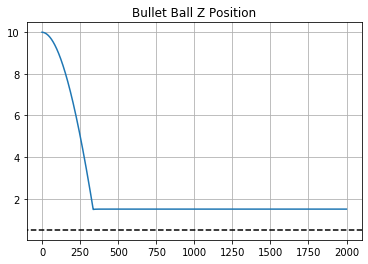

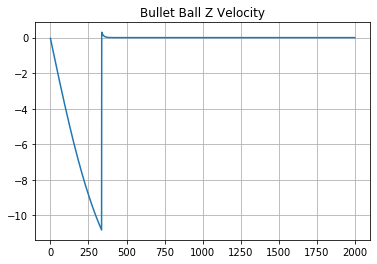

In [24]:
# Plotting

plt.plot(bullet_z)
plt.title("Bullet Ball Z Position")
plt.axhline(.5, -1, 11,color='k',  linestyle='dashed')
plt.grid()

plt.figure()

plt.plot(bullet_dz)
plt.title("Bullet Ball Z Velocity")
plt.grid()

In [14]:
## Now we set up the mujoco version of the ball drop 

import mujoco_py as mj
import numpy as np
import matplotlib.pyplot as plt
model = mj.load_model_from_path("/home/sgillen/work/contact/bullet_inv/ball.xml")
sim = mj.MjSim(model)

In [15]:
## Run the simulation

ep_len = 2000

qpos = np.zeros((ep_len,3))
qvel = np.zeros((ep_len,3))

for i in range(ep_len):
    sim.step()
    #viewer.render()
    qpos[i,:] = np.copy(sim.data.qpos)
    qvel[i,:] = np.copy(sim.data.qvel)

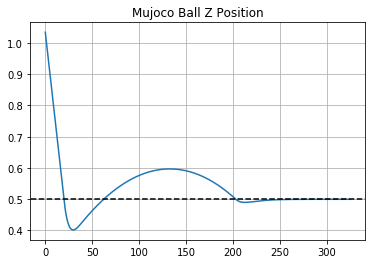

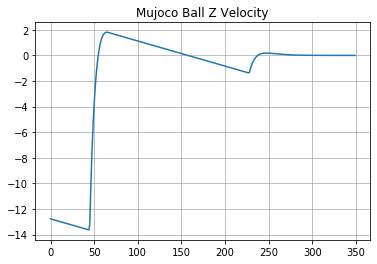

In [16]:
## Plotting

plt.plot(qpos[675:1000,1]+10.0)
plt.title("Mujoco Ball Z Position")
plt.axhline(.5, -1, 11,color='k',  linestyle='dashed')
plt.grid()

plt.figure()
plt.plot(qvel[650:1000,1])
plt.title("Mujoco Ball Z Velocity")
plt.grid()

In [56]:
## Doing some analysis on the Z coordinate, can probably ignore everything after this

z = qpos[:,1]+10 # +10 needed to account for mujoco calling whatever the initial is 0
dz= qvel[:,1]

start_idx = np.where(z <=.5)[0][0]  
end_idx = np.where(z[start_idx:] >= .5)[0][0] + start_idx

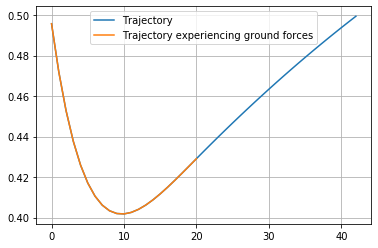

In [44]:
plt.plot(z[start_idx:end_idx])
ydata = np.stack([z[start_idx:end_idx], dz[start_idx:end_idx]],axis=-1)
ydata.shape
plt.plot(z[start_idx:start_idx+21])
plt.legend(["Trajectory", "Trajectory experiencing ground forces"])
plt.grid()


In [63]:
import scipy.optimize as opt
#end_idx = start_idx+21 #hack

xdata = np.stack([qpos[start_idx:end_idx,1]+10,qvel[start_idx:end_idx,1]], axis=-1)
acc = [(dz[start_idx+(i+1)]-dz[start_idx+(i)])/.002 for i in range(end_idx-start_idx)]

def acc_fcn(x, k, b):
    return (-k*(x[:,0]-.5) - b*x[:,1] - 9.8)/10

popt, pcov = opt.curve_fit(acc_fcn, xdata, np.array(acc))

In [64]:
popt

array([25072.66239929,   907.37379609])

In [5]:
plt.plot(acc_fcn(xdata,*popt))

NameError: name 'acc_fcn' is not defined

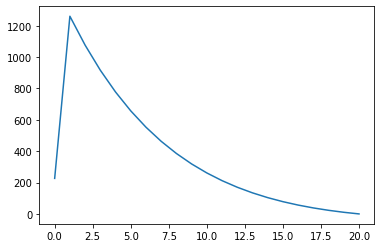

In [129]:
plt.plot(acc)